# Experiment 02: Influence of weight coefficients

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

## Loading data 2D

/Users/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


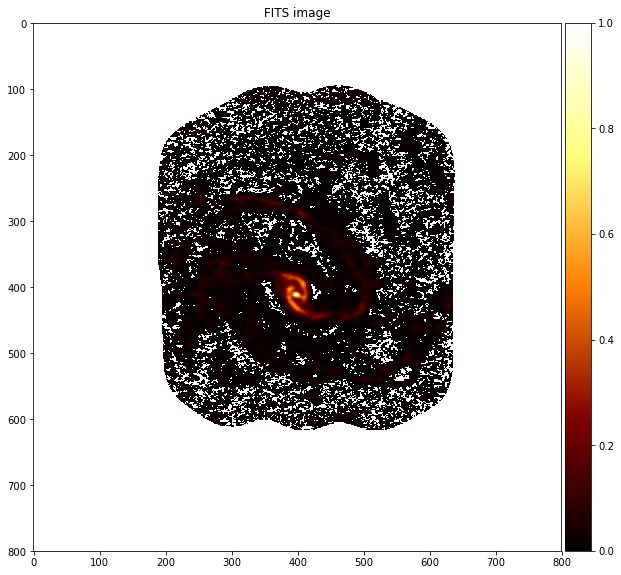

In [2]:
"""
Loading data
"""

fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3883: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  check = self.filled(0).__eq__(other)


<function graph.thresholded_image_plot>

## `Case 1 `:   $\alpha_1 = 0$ and $\alpha_2 =0$

../lib/points_generation.py:28: RuntimeWarning: invalid value encountered in less_equal
  mask = data <= base_level


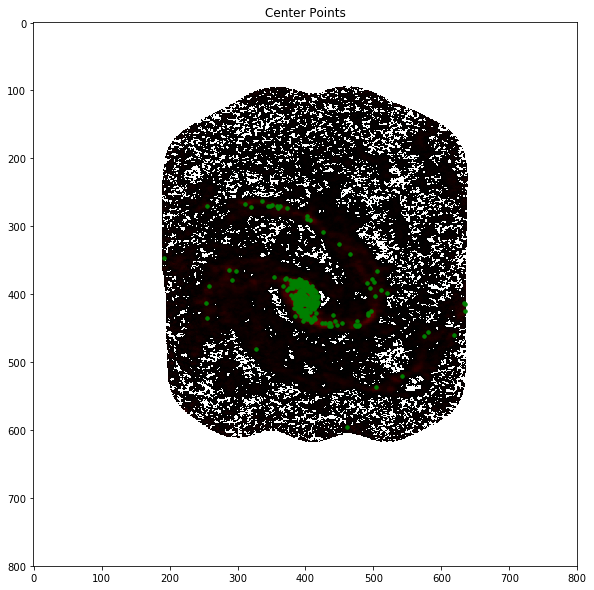

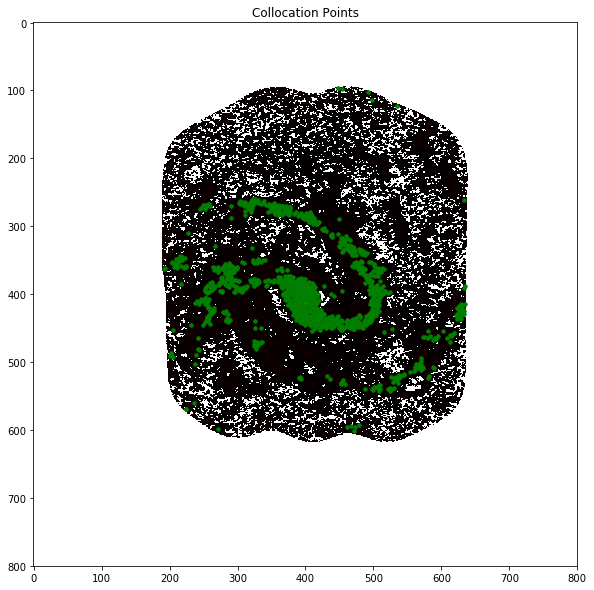

../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100115

Residual stats:
Residual RMS: 0.051930371015700895
Residual Variance: 0.0006258174765076985
Residual Entropy: 4.126933919286195
Added Flux: 14.468387000028773
Total elapsed time: 249.41882967948914 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.2631907648552102
Mean min distance between collocation and center points: 0.014435273596958275

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.05138552062543533
Max min distance in the (standarized) parameters space: 0.4663938636468697


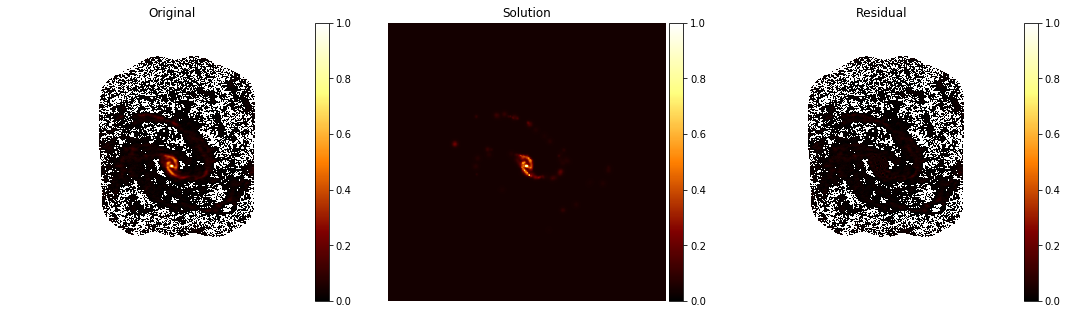

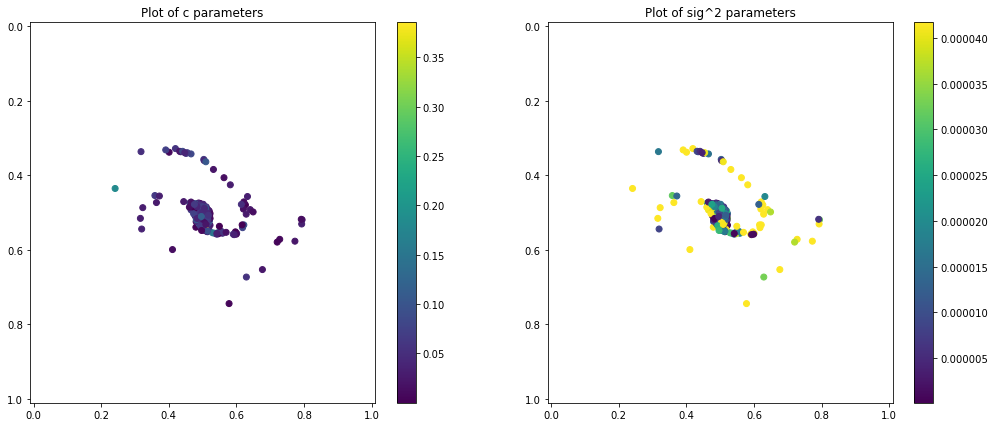

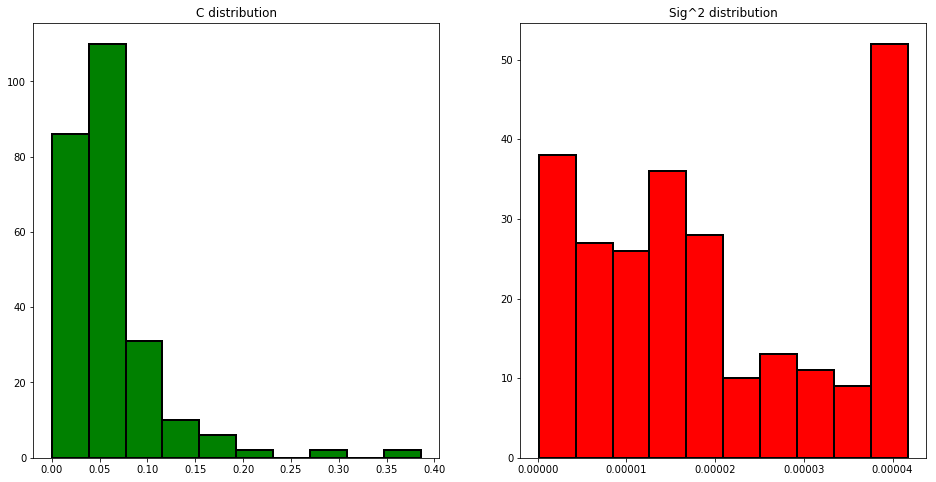

In [4]:
# common parameters
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig

# number of points of each type
Nb = 50
Nc = 250
Ne = 4*Nc-Nb

# points generation
center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


#solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
#params_plot(c0, sig0, xc, yc)
#params_distribution_plot(c0, sig0)
elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=0., lamb1=1., b=0., lamb2=1.,
                d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

## `Case 2 `:   $\alpha_1 = 1.$ and $\alpha_2 =0$

../lib/points_generation.py:28: RuntimeWarning: invalid value encountered in less_equal
  mask = data <= base_level
../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100136

Residual stats:
Residual RMS: 0.07999096525794845
Residual Variance: 0.002156110381144761
Residual Entropy: 3.9562234309921136
Added Flux: 20.460698746028115
Total elapsed time: 269.88749384880066 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.26223997921915454
Mean min distance between collocation and center points: 0.014485751933219264

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.04758755347131315
Max min distance in the (standarized) parameters space: 0.7143823789341105


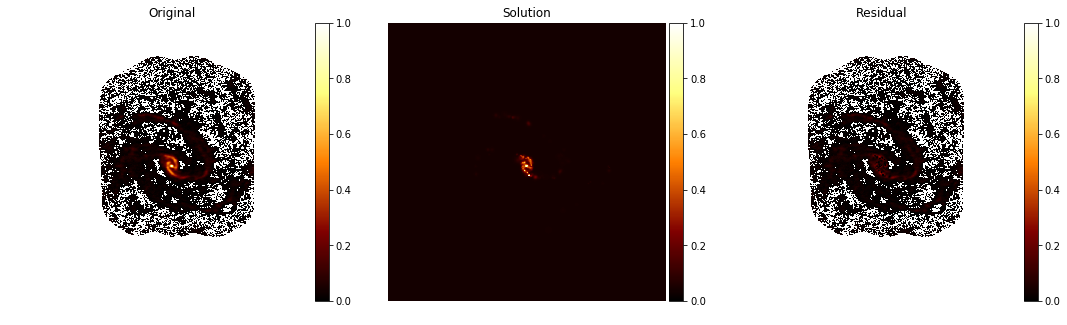

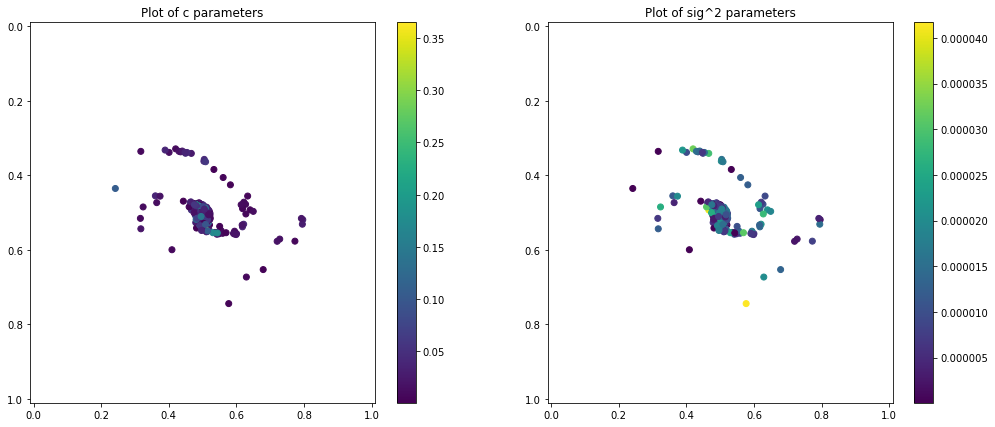

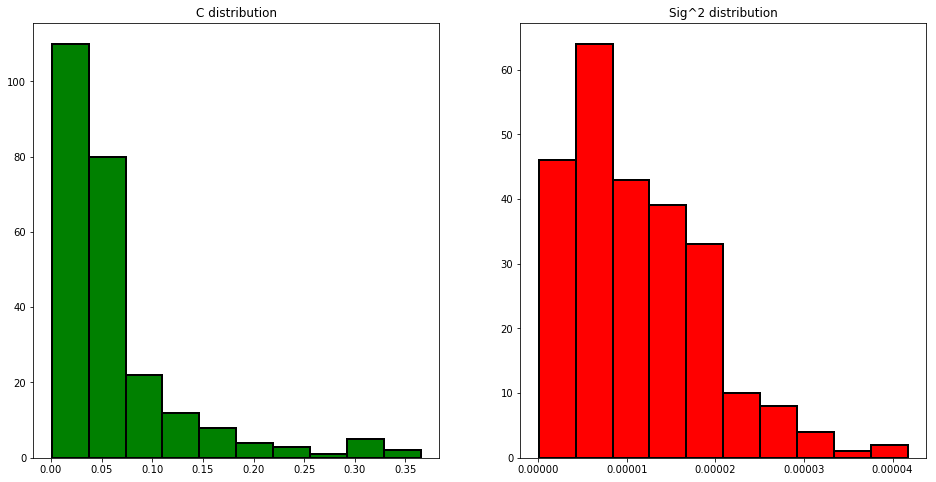

In [5]:
# common parameters
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig

# number of points of each type
Nb = 50
Nc = 250
Ne = 4*Nc-Nb

# points generation
center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## visualizing the choosen points
#points_plot(data, center_points=center_points, title="Center Points")
#points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


#solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
#params_plot(c0, sig0, xc, yc)
#params_distribution_plot(c0, sig0)
elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=10., lamb1=10., b=0., lamb2=1.,
                d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

## `Case 3 `:   $\alpha_1 = 0$ and $\alpha_2 = 1e-4$

../lib/points_generation.py:28: RuntimeWarning: invalid value encountered in less_equal
  mask = data <= base_level
../lib/variational.py:79: RuntimeWarning: invalid value encountered in greater
  self.mask = data > base_level



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 21039

Residual stats:
Residual RMS: 0.0666978024664061
Residual Variance: 0.001887595202779787
Residual Entropy: 3.9424761618251436
Added Flux: 33.43328661371941
Total elapsed time: 86.21722984313965 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.2623021171644346
Mean min distance between collocation and center points: 0.014594159911318048

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.041864361767299824
Max min distance in the (standarized) parameters space: 0.6066311917357549


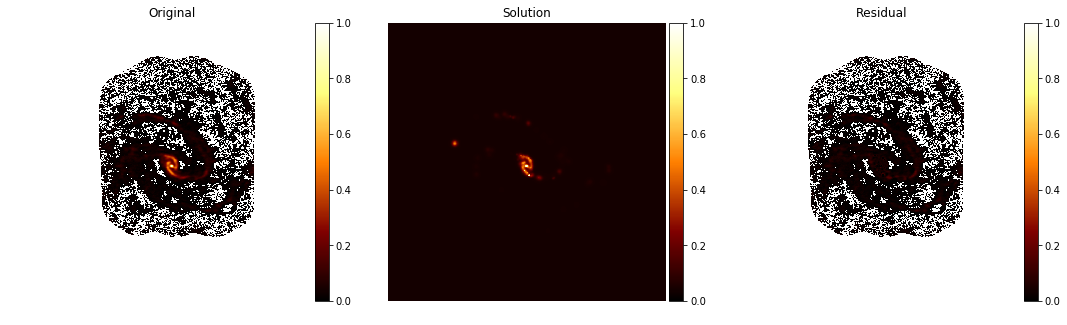

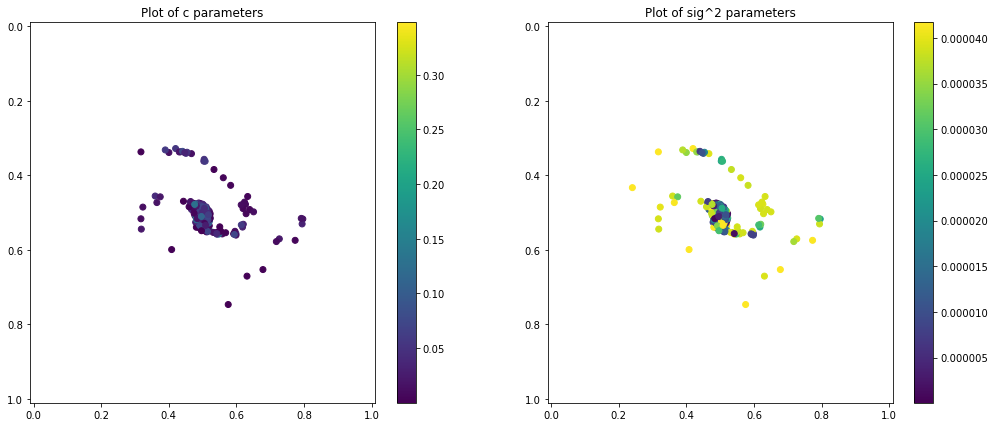

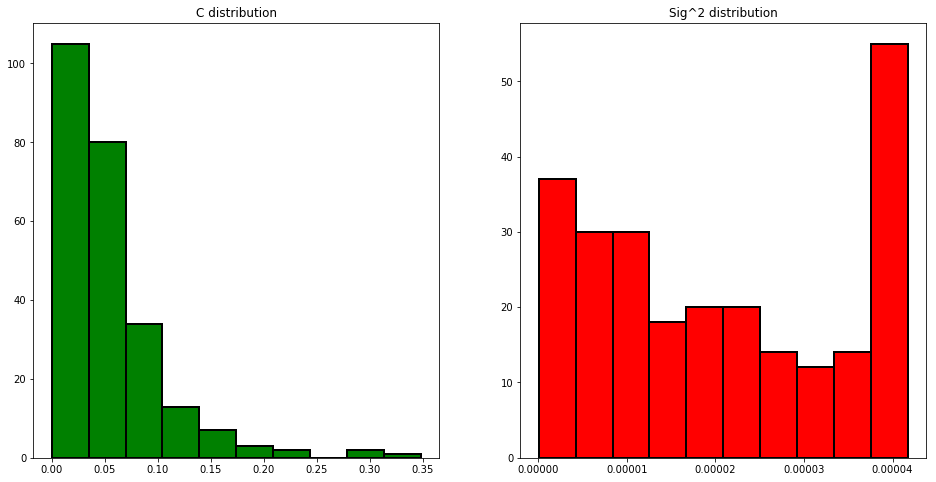

In [6]:
# common parameters
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig

# number of points of each type
Nb = 50
Nc = 250
Ne = 4*Nc-Nb

# points generation
center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## visualizing the choosen points
#points_plot(data, center_points=center_points, title="Center Points")
#points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


#solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
#params_plot(c0, sig0, xc, yc)
#params_distribution_plot(c0, sig0)
elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=0., lamb1=1., b=1e-3, lamb2=1.,
                d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

nfev = 100*(len(elm03.get_params())+1)
elm_solver(elm03, method='standard', max_nfev=nfev)

## `Case 4 `:   $\alpha_1 = 1$ and $\alpha_2 =1e-4$


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 2
message: The relative error between two consecutive iterates is at most 0.000000
nfev: 7217

Residual stats:
Residual RMS: 0.20064046626582063
Residual Variance: 0.014395083149585293
Residual Entropy: 6.929528596304131
Total elapsed time: 3644.748876094818 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.02661033443376027
Mean min distance between collocation and center points: 0.00799379974084039

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.04973022530983419
Max min distance in the (standarized) parameters space: 0.42922643022077195


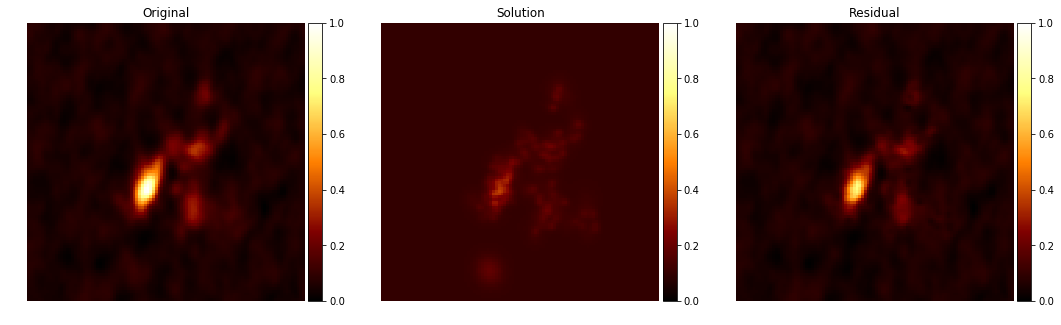

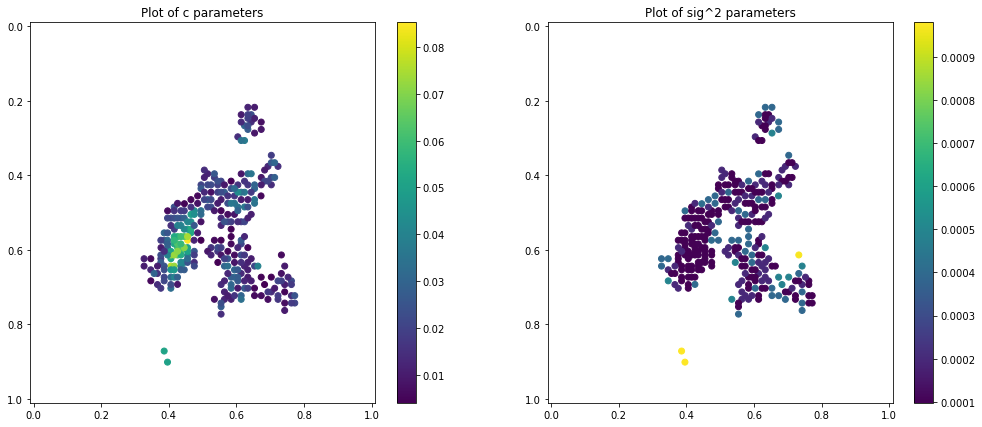

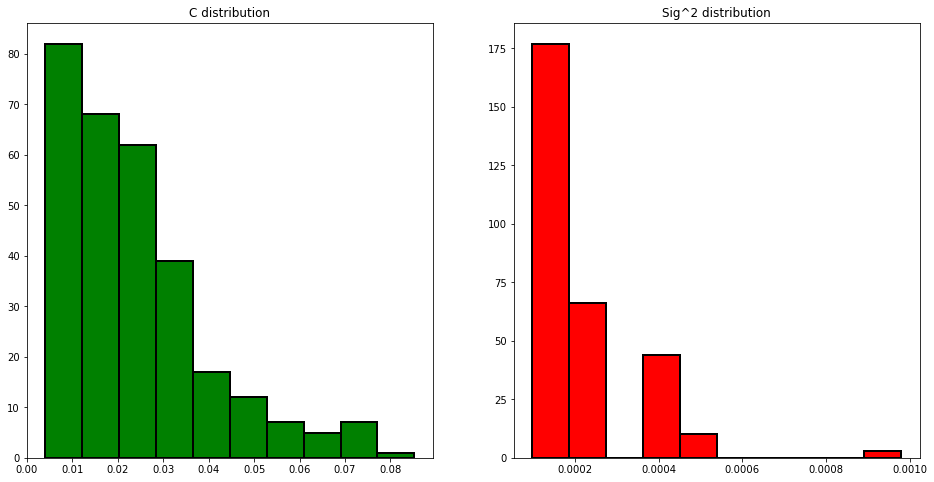

In [22]:
# common parameters
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig

# number of points of each type
Nb = 75
Nc = 300
Ne = 4*Nc-Nb

# points generation
center_points = random_centers_generation(data, Nc, base_level=base_level, power=2.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## visualizing the choosen points
#points_plot(data, center_points=center_points, title="Center Points")
#points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
#c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


#solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
#params_plot(c0, sig0, xc, yc)
#params_distribution_plot(c0, sig0)
elm04 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., b=1e-3, lamb2=1.,
                d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

nfev = 100*(len(elm04.get_params())+1)
elm_solver(elm04, method='standard', max_nfev=nfev)